<h1><center>Лабораторна робота 2.</center></h1>
<h2><center>Візуальний аналіз даних серцево-судинних захворювань</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

У цьому завданні ви дасте відповідь на кілька запитань щодо набору даних про серцево-судинні захворювання.

#### Опис задачі

Виконайте візуальний аналіз даних та зробіть прогноз на його основі наявності або відсутності серцево-судинних захворювань (ССЗ) за результатами обстеження пацієнта.

#### Опис даних

Є 3 типи вхідних ознак:

- *Об'єктивна інформація*: фактична інформація про пацієнта;
- *Огляд*: результати медичного огляду;
- *Суб'єктивна інформація*: інформація, надана пацієнтом.

| Feature                                       | Variable Type       | Variable    | Value Type                                       |
|-----------------------------------------------|---------------------|-------------|--------------------------------------------------|
| Age                                           | Objective Feature   | age         | int (days)                                       |
| Height                                        | Objective Feature   | height      | int (cm)                                         |
| Weight                                        | Objective Feature   | weight      | float (kg)                                       |
| Gender                                        | Objective Feature   | gender      | categorical code                                 |
| Systolic blood pressure                       | Examination Feature | ap_hi       | int                                              |
| Diastolic blood pressure                      | Examination Feature | ap_lo       | int                                              |
| Cholesterol                                   | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose                                       | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Smoking                                       | Subjective Feature  | smoke       | binary                                           |
| Alcohol intake                                | Subjective Feature  | alco        | binary                                           |
| Physical activity                             | Subjective Feature  | active      | binary                                           |
| Presence or absence of cardiovascular disease | Target Variable     | cardio      | binary                                           |


Усі значення набору даних були зібрані на момент медичного огляду.

# Частина 1. Попередній аналіз даних

Спершу ознайомимося з нашими даними, провівши попередній аналіз даних. Ініціалізуємо середовище:

In [1]:
# Імпортуємо всі необхідні модулі
import pandas as pd
import numpy as np

# Вимикаємо попередження
import warnings
warnings.filterwarnings("ignore")

# Імпортуємо графічні бібліотеки
import seaborn as sns
sns.set_theme()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Ми будемо використовувати бібліотеку `seaborn` для візуального аналізу, тому підготуємо і її:

In [2]:
# Налаштуємо візуальні параметри для графіків у `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
#%config InlineBackend.figure_format = 'svg'

Для простоти роботи ми будемо працювати лише з навчальною частиною набору даних:

In [3]:
data_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-02_visual-analyzing-cvd/cvd_train.csv'
df = pd.read_csv(data_url, sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Буде також корисно заглянути в значення наших змінних.
 
Давайте перетворимо дані у формат *long* і зобразимо кількість значень категорійних ознак за допомогою [`catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html).

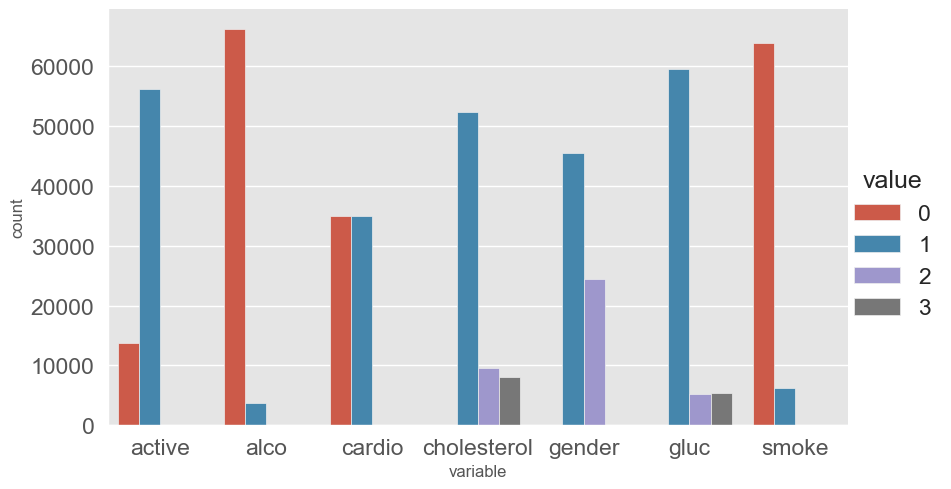

In [4]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            data=df_uniques, kind='bar', aspect=1.75)

Ми бачимо, що цільові класи збалансовані. Це чудово!

Далі розділимо набір даних за цільовими значеннями. Чи можете ви вже помітити найважливішу ознаку, просто глянувши на графік?

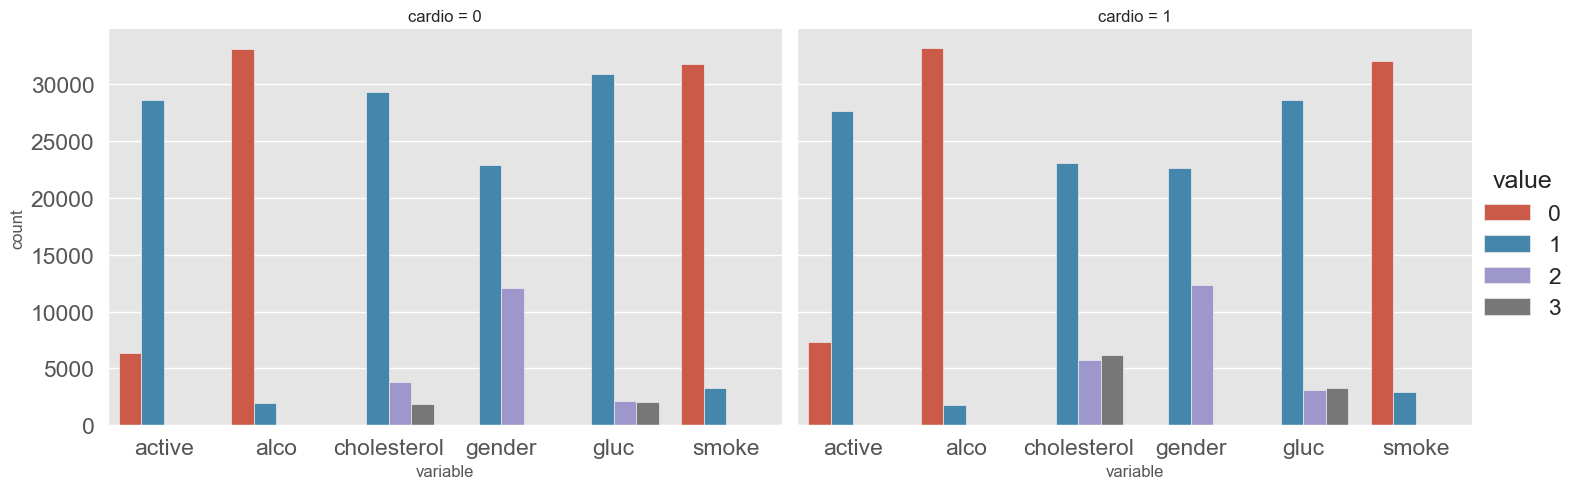

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', aspect=1.5)

Бачимо, що розподіл рівнів холестерину та глюкози сильно відрізняється за значенням цільової змінної. Це випадковість?

Тепер обчислимо деякі статистичні показники для унікальних значень ознак:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


У підсумку, маємо:
- 5 числових ознак (за винятком *id*);
- 7 категоріальних ознак;
- Всього 70000 записів.

## 1.1. Основні спостереження

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

**Варіант 1:** Визначте середній систолічний тиск (`ap_hi`) та діастолічний тиск (`ap_lo`) для кожної категорії холестерину (`cholesterol`). Чи спостерігається тенденція збільшення тиску зі зростанням рівня холестерину? Візуалізуйте результати за допомогою стовпчикових діаграм.

**Варіант 2:** Проаналізуйте розподіл віку (`age`) пацієнтів за категоріями активності (`active`). Чи є значуща різниця у віковому складі між активними та неактивними пацієнтами? Візуалізуйте розподіл за допомогою гістограм.

**Варіант 3:** Визначте кількість пацієнтів у кожній категорії глюкози (`gluc`) для кожної статі (`gender`). Чи спостерігається відмінність у розподілі глюкози між чоловіками та жінками? Візуалізуйте дані за допомогою групових стовпчикових діаграм.

**Варіант 4:** Визначте розподіл статі (`gender`) поміж пацієнтів із різними рівнями активності (`active`). Чи є переважання певної статі в активних або неактивних групах? Візуалізуйте результати за допомогою кругових діаграм.

**Варіант 5:** Проаналізуйте розподіл зросту (`height`) пацієнтів у вікових групах. Розділіть вік на категорії (наприклад, 30–40, 41–50 років) та побудуйте боксплоти для кожної групи, щоб визначити медіану та розмахи зросту.

**Варіант 6:** Дослідіть вплив вживання алкоголю (`alco`) на рівень холестерину (`cholesterol`). Чи є зв’язок між цими двома показниками? Візуалізуйте дані за допомогою струнних діаграм (`stripplot`).

**Варіант 7:** Дослідіть розподіл систолічного тиску (`ap_hi`) поміж різних категорій активності (`active`). Чи є значущі відмінності між активними та неактивними пацієнтами? Візуалізуйте дані за допомогою `Violin Plot`.

**Варіант 8:** Визначте кількість пацієнтів у кожній категорії холестерину (`cholesterol`) та глюкози (`gluc`). Чи є взаємозв’язок між рівнями цих двох показників? Візуалізуйте результати за допомогою `scatterplot`.

**Варіант 9:** Проаналізуйте розподіл діастолічного тиску (`ap_lo`) поміж різних рівнів холестерину (`cholesterol`). Чи спостерігається підвищення діастолічного тиску з ростом рівня холестерину? Візуалізуйте дані за допомогою лінійних графіків.

**Варіант 10:** Визначте, чи відрізняється середній вік пацієнтів із високим рівнем холестерину (`cholesterol`=3) від тих із низьким (`cholesterol`=1). Використовуйте тест на значущість середніх та візуалізуйте результати за допомогою `boxplot`.

**Варіант 11:** Проаналізуйте розподіл віку (`age`) поміж пацієнтів із різними рівнями діастолічного тиску (`ap_lo`). Чи є тенденція підвищення віку з ростом діастолічного тиску? Візуалізуйте дані за допомогою `lineplot`.

**Варіант 12:** Визначте, яка категорія холестерину (`cholesterol`) має найвищу середню вагу (`weight`). Використовуйте `groupby` та `agg` для обчислення середніх значень та візуалізуйте результати за допомогою стовпчикової діаграми.

**Варіант 13:** Дослідіть вплив куріння (`smoke`) на рівень активності (`active`). Чи є зв’язок між цими двома ознаками? Візуалізуйте взаємозв’язок за допомогою `scatterplot` або `jointplot`.

**Варіант 14:** Проаналізуйте розподіл віку (`age`) поміж пацієнтів із різними рівнями холестерину (`cholesterol`). Чи є тенденція збільшення віку зі зростанням рівня холестерину? Візуалізуйте дані за допомогою `lineplot`.

**Варіант 15:** Проаналізуйте розподіл віку (`age`) поміж пацієнтів із різними рівнями активності (`active`). Чи є різниця в середньому віці між активними та неактивними пацієнтами? Візуалізуйте дані за допомогою `violinplot`.

**Варіант 16:** Визначте, яка категорія глюкози (`gluc`) має найнижчий середній систолічний тиск (`ap_hi`). Чи можна стверджувати, що нижчий рівень глюкози пов’язаний із нижчим тиском? Візуалізуйте результати за допомогою `barplot`.

**Варіант 17:** Проаналізуйте вплив статі (`gender`) на рівень глюкози (`gluc`). Чи є різниця в розподілі глюкози між чоловіками та жінками? Візуалізуйте дані за допомогою `countplot`.

**Варіант 18:** Визначте, чи впливає рівень холестерину (`cholesterol`) на рівень активності (`active`) у пацієнтів. Використовуйте `scatterplot` або `jointplot` для візуалізації взаємозв’язку.

**Варіант 19:** Проаналізуйте розподіл діастолічного тиску (`ap_lo`) поміж пацієнтів із різними рівнями активності (`active`). Чи є тенденція підвищення діастолічного тиску зі зниженням активності? Візуалізуйте дані за допомогою `boxplot`.

**Варіант 20:** Визначте, яка категорія алкоголю (`alco`) має найвищу середню вагу (`weight`). Чи є зв’язок між вживанням алкоголю та вагою? Візуалізуйте результати за допомогою `barplot`.

## 1.2. Мапи ризиків

На вебсайті Європейського товариства кардіологів надається [шкала SCORE](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts). Вона використовується для розрахунку ризику смерті від серцево-судинного захворювання в найближчі 10 років. Ось вона:

<img src=https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/2_3_risk-map.png width=50%>

Глянемо на верхній правий прямокутник, який показує підгрупу курців у віці від 60 до 65 років. (Це неочевидно, але значення на мапі відображають верхню межу).

Ми бачимо значення 9 у нижньому лівому куті прямокутника та 47 у верхньому правому. Це означає, що для людей-курців цієї статево-вікової групи, у яких систолічний тиск менше 120 (сегмент 1), ризик серцево-судинних захворювань оцінюється в 5 разів нижче, ніж для тих курців, хто має тиск в інтервалі [160, 180) (сегмент 2).

Далі обчисліть цей коефіцієнт, використовуючи статистичні дані.

Уточнення:
- Розрахувати ознаку ``age_years`` – округлити вік до найближчої кількості років. Для цього завдання відбирайте лише людей віком [60;64].
- Категорії рівня холестерину відрізняються між цифрою та нашим набором даних. Перерахунок для ознаки ``cholesterol`` наступний: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

**Варіант 1:** Проаналізуйте вплив вживання алкоголю (`alco`) та куріння (`smoke`) на ризик ССЗ. Обчисліть ризик для кожної комбінації цих двох чинників та візуалізуйте результати за допомогою `barplot`.

**Варіант 2:** Визначте, як змінюється ризик ССЗ зі зростанням віку (`age_years`). Створіть лінійний графік за допомогою `Seaborn.lineplot`, показуючи залежність ризику від віку.

**Варіант 3:** Дослідіть взаємозв’язок між індексом маси тіла (`bmi`) та ризиком ССЗ. Обчисліть середній ризик для різних діапазонів ІМТ та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 4:** Проаналізуйте, як впливає рівень фізичної активності (`active`) на ризик ССЗ у різних вікових групах. Побудуйте `facetgrid` з використанням `Seaborn`, щоби показати відокремлені графіки для кожної вікової групи.

**Варіант 5:** Визначте, який вплив має рівень діастолічного тиску (`ap_lo`) на ризик ССЗ у різних категоріях холестерину (`cholesterol`). Візуалізуйте дані за допомогою `boxplot`.

**Варіант 6:** Проаналізуйте співвідношення між систолічним тиском (`ap_hi`) та ризиком ССЗ для різних рівнів глюкози (`gluc`). Використовуйте `scatterplot` з кольоровим розділенням за `gluc`.

**Варіант 7:** Визначте, чи є взаємозв’язок між вагою (`weight`) та ризиком ССЗ у різних категоріях холестерину (`cholesterol`). Візуалізуйте дані за допомогою `jointplot`.

**Варіант 8:** Визначте, яка комбінація високого рівня глюкози (`gluc`=3) та високого рівня холестерину (`cholesterol`=3) має найвищий ризик ССЗ. Обчисліть цей ризик та візуалізуйте дані за допомогою `barplot`.

**Варіант 9:** Дослідіть, як змінюється ризик ССЗ залежно від віку (`age_years`) та рівня фізичної активності (`active`). Створіть 3D графік за допомогою `Plotly`, показуючи залежність ризику від цих двох чинників.

**Варіант 10:** Проаналізуйте, чи впливає рівень холестерину (`cholesterol`) на зв’язок між віком (`age_years`) та ризиком ССЗ. Створіть `lmplot`, показуючи регресію для кожної категорії холестерину.

**Варіант 11:** Проаналізуйте, як ризик ССЗ змінюється залежно від рівня глюкози (`gluc`) та зросту (`height`). Створіть `jointplot` з розподілом ризику по обох осях.

**Варіант 12:** Проаналізуйте, як ризик ССЗ змінюється з вагою (`weight`) у різних вікових групах. Створіть `FacetGrid` з використанням `Seaborn`, щоби показати відокремлені графіки для кожної вікової групи.

**Варіант 13:** Визначте, чи впливає рівень холестерину (`cholesterol`) на зв’язок між вагою (`weight`) та ризиком ССЗ. Створіть `pairplot`, показуючи взаємозв’язок між цими трьома ознаками для кожної категорії холестерину.

**Варіант 14:** Проаналізуйте, чи є залежність між рівнем фізичної активності (`active`) та ризиком ССЗ у різних рівнях діастолічного тиску (`ap_lo`). Створіть `scatterplot` з регресійною лінією для кожної категорії `ap_lo`.

**Варіант 15:** Визначте, чи впливає рівень діастолічного тиску (`ap_lo`) на ризик ССЗ у різних вікових групах. Створіть `boxplot`, показуючи розподіл `ap_lo` для кожної вікової групи з розділенням за ризиком ССЗ.

**Варіант 16:** Проаналізуйте, як змінюється ризик ССЗ залежно від рівня холестерину (`cholesterol`) та діастолічного тиску (`ap_lo`). Створіть 3D графік за допомогою `Plotly`, показуючи залежність ризику від цих двох чинників.

**Варіант 17:** Визначте, чи є взаємозв’язок між індексом маси тіла (`bmi`) та ризиком ССЗ у різних категоріях фізичної активності (`active`). Використовуйте `pairplot` для візуалізації взаємозв’язку між цими трьома ознаками.

**Варіант 18:** Проаналізуйте, як змінюється ризик ССЗ залежно від рівня холестерину (`cholesterol`) та фізичної активності (`active`) у різних вікових групах. Створіть `FacetGrid` з використанням `Seaborn`, щоби показати відокремлені графіки для кожної вікової групи.

**Варіант 19:** Проаналізуйте, як ризик ССЗ змінюється з вагою (`weight`) у різних категоріях діастолічного тиску (`ap_lo`). Створіть `boxplot`, показуючи розподіл ризику для кожної категорії `ap_lo`.

**Варіант 20:** Визначте, чи є взаємозв’язок між рівнем активності (`active`) та ризиком ССЗ у різних вікових групах. Створіть `FacetGrid` з використанням `Seaborn`, щоби показати відокремлені графіки для кожної вікової групи.

## 1.3. Аналіз ІМТ

### <span style="color:red; font-size:1.5em;">Завдання 3</span>

**Варіант 1:** Проаналізуйте розподіл ІМТ поміж пацієнтів з різними рівнями холестерину (`cholesterol`). Чи є тенденція збільшення ІМТ зі зростанням рівня холестерину? Візуалізуйте результати за допомогою `boxplot`.

**Варіант 2:** Визначте, чи є різниця в ІМТ між пацієнтами різного віку (`age_years`). Створіть `violinplot`, щоб показати розподіл ІМТ для різних вікових груп.

**Варіант 3:** Визначте, чи є різниця в ІМТ між курцями (`smoke`) та некурцями. Створіть `barplot`, що показує середній ІМТ для кожної групи.

**Варіант 4:** Проаналізуйте вплив вживання алкоголю (`alco`) на ІМТ пацієнтів. Чи мають люди, які вживають алкоголь, вищий ІМТ порівняно з тими, хто не вживає? Візуалізуйте результати за допомогою `boxplot`.

**Варіант 5:** Проаналізуйте розподіл ІМТ поміж різних рівнів систолічного тиску (`ap_hi`). Чи є тенденція збільшення ІМТ зі зростанням тиску? Візуалізуйте дані за допомогою `lineplot`.

**Варіант 6:** Визначте, чи є різниця в ІМТ між чоловіками та жінками (`gender`). Створіть `stripplot`, щоб показати розподіл ІМТ для кожної статі.

**Варіант 7:** Проаналізуйте, як змінюється ІМТ з віком (`age_years`) для пацієнтів з різними рівнями глюкози (`gluc`). Створіть `FacetGrid` з використанням `Seaborn`, щоб показати окремі графіки для кожного рівня глюкози.

**Варіант 8:** Визначте, яка категорія фізичної активності (`active`) має найвищий середній ІМТ. Чи можна стверджувати, що менш активні пацієнти мають вищий ІМТ? Візуалізуйте результати за допомогою `barplot`.

**Варіант 9:** Визначте, чи є різниця в ІМТ між пацієнтами з різними рівнями глюкози (`gluc`). Створіть `boxplot`, що показує розподіл ІМТ для кожного рівня глюкози.

**Варіант 10:** Проаналізуйте вплив куріння (`smoke`) на ІМТ пацієнтів. Чи мають курці вищий ІМТ порівняно з некурцями? Візуалізуйте результати за допомогою `boxplot`.

**Варіант 11:** Проаналізуйте розподіл ІМТ поміж пацієнтів з різними рівнями систолічного тиску (`ap_hi`). Чи є тенденція збільшення ІМТ зі зростанням тиску? Візуалізуйте дані за допомогою `lineplot`.

**Варіант 12:** Визначте, чи є різниця в ІМТ між пацієнтами з різними категоріями рівня глюкози (`gluc`). Створіть `violinplot`, що показує розподіл ІМТ для кожної категорії глюкози.

**Варіант 13:** Проаналізуйте вплив статі (`gender`) на розподіл ІМТ. Створіть `FacetGrid` з використанням `Seaborn`, щоб показати окремі графіки для чоловіків та жінок.

**Варіант 14:** Визначте, чи є взаємозв'язок між ІМТ (`bmi`) та рівнем фізичної активності (`active`) у різних категоріях глюкози (`gluc`). Створіть `heatmap`, що показує середній ІМТ для кожної комбінації цих факторів.

**Варіант 15:** Визначте, чи є різниця в ІМТ між пацієнтами з різними рівнями фізичної активності (`active`) та рівнями глюкози (`gluc`). Створіть `pairplot`, показуючи взаємозв'язок між цими трьома ознаками.

**Варіант 16:** Проаналізуйте, як ІМТ (`bmi`) змінюється з віком (`age_years`) у різних категоріях рівня фізичної активності (`active`). Створіть `FacetGrid` з використанням `Seaborn`, щоб показати окремі графіки для кожної категорії активності.

**Варіант 17:** Визначте, чи є взаємозв'язок між рівнем активності (`active`) та рівнем діастолічного тиску (`ap_lo`). Створіть `heatmap`, що показує середній ІМТ для кожної комбінації цих двох факторів.

**Варіант 18:** Проаналізуйте розподіл ІМТ поміж пацієнтів з різними рівнями систолічного тиску (`ap_hi`) та рівнями глюкози (`gluc`). Створіть `pairplot`, показуючи взаємозв'язок між ІМТ, тиском та глюкозою.

**Варіант 19:** Визначте, яка категорія глюкози (`gluc`) має найнижчий середній ІМТ. Чи можна стверджувати, що нижчий рівень глюкози пов'язаний з нижчим ІМТ? Візуалізуйте результати за допомогою `barplot`.

**Варіант 20:** Визначте, чи є взаємозв'язок між ІМТ (`bmi`) та рівнем фізичної активності (`active`) у різних категоріях рівня холестерину (`cholesterol`). Створіть `heatmap`, що показує середній ІМТ для кожної комбінації цих трьох факторів.

## 1.4. Очищення даних

Варто пам'ятати, дані не є ідеальними. Набір містить зайву інформацію та неточності. Візуалізуємо дані, щоби побачити це наочно.

### <span style="color:red; font-size:1.5em;">Завдання 4</span>

**Варіант 1:** Відфільтруйте (приберіть) пацієнтів з вагою менш як 30 кг. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою кругової діаграми.

**Варіант 2:** Відфільтруйте (приберіть) пацієнтів з віком менш як 18 років. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою гістограми.

**Варіант 3:** Відфільтруйте (приберіть) пацієнтів зі систолічним тиском (`ap_hi`) менш як 90 мм рт. ст. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою стовпчикової діаграми.

**Варіант 4:** Відфільтруйте (приберіть) пацієнтів з діастолічним тиском (`ap_lo`) менш як 60 мм рт. ст. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою бічного гістограмного графіка.

**Варіант 5:** Відфільтруйте (приберіть) пацієнтів з рівнем глюкози (`gluc`) понад 3. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою точкової діаграми.

**Варіант 6:** Відфільтруйте (приберіть) пацієнтів з невалідними значеннями ваги (`weight`) або зросту (`height`), тобто вага менш як 20 кг або зріст менш як 100 см. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою кругової діаграми.

**Варіант 7:** Відфільтруйте (приберіть) пацієнтів зі зростом понад 200 см. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою гістограми.

**Варіант 8:** Відфільтруйте (приберіть) пацієнтів з вагою понад 150 кг. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою стовпчикової діаграми.

**Варіант 9:** Відфільтруйте (приберіть) пацієнтів з рівнем холестерину (`cholesterol`) менш як 1 або понад 3. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою точкової діаграми.

**Варіант 10:** Відфільтруйте (приберіть) пацієнтів з рівнем глюкози (`gluc`) менш як 1 або понад 3. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою бічного гістограмного графіка.

**Варіант 11:** Відфільтруйте (приберіть) пацієнтів, у яких рівень фізичної активності (`active`) не є 0 або 1. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою кругової діаграми.

**Варіант 12:** Відфільтруйте (приберіть) пацієнтів, які не вживають алкоголь (`alco`=0) та не курять (`smoke`=0). Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою стовпчикової діаграми.

**Варіант 13:** Відфільтруйте (приберіть) пацієнтів з невалідними комбінаціями систолічного та діастолічного тиску, де різниця між ними перевищує 50 мм рт. ст. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою точкової діаграми.

**Варіант 14:** Відфільтруйте (приберіть) пацієнтів з відсутніми значеннями в ознаках `height`, `weight`, `ap_hi`, `ap_lo`, `cholesterol`, `gluc`. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою кругової діаграми.

**Варіант 15:** Відфільтруйте (приберіть) пацієнтів, у яких зріст (`height`) менш як 140 см або понад 210 см. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою гістограми.

**Варіант 16:** Відфільтруйте (приберіть) пацієнтів з вагою (`weight`) менш як 40 кг або понад 130 кг. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою стовпчикової діаграми.

**Варіант 17:** Відфільтруйте (приберіть) пацієнтів з рівнем холестерину (`cholesterol`) не дорівнює 1, 2 або 3. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою точкової діаграми.

**Варіант 18:** Відфільтруйте (приберіть) пацієнтів, які мають відсутні або негативні значення в ознаці `age_years`. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою кругової діаграми.

**Варіант 19:** Відфільтруйте (приберіть) пацієнтів з рівнем глюкози (`gluc`) не дорівнює 1, 2 або 3. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою бічного гістограмного графіка.

**Варіант 20:** Відфільтруйте (приберіть) пацієнтів з невалідними комбінаціями зросту (`height`) та ваги (`weight`), де ІМТ (`bmi`) менш як 15 або понад 40. Скільки відсотків початкових даних (округлених) було відкинуто? Візуалізуйте результат за допомогою точкової діаграми.

# Частина 2. Візуальний аналіз даних. Кореляційний аналіз.

Щоб краще зрозуміти ознаки, проведемо кореляційний аналіз з відфільтрованим набором даних.

### <span style="color:red; font-size:1.5em;">Завдання 5</span>

**Варіант 1:** Дослідіть співвідношення між віком (`age`) та вагою (`weight`) пацієнтів. Чи є кореляція між цими двома показниками? Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте розподіл за допомогою точкової діаграми.

**Варіант 2:** Проаналізуйте розподіл зросту (`height`) та ваги (`weight`) пацієнтів. Чи є кореляція між цими двома показниками? Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 3:** Визначте, як змінюється середній рівень глюкози (`gluc`) з віком (`age`). Побудуйте графік лінійної регресії за допомогою `Seaborn.regplot` та обчисліть коефіцієнт кореляції.

**Варіант 4:** Проаналізуйте співвідношення між зростом (`height`) та рівнем глюкози (`gluc`). Чи є кореляція між цими двома показниками? Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою `scatterplot`.

**Варіант 5:** Проаналізуйте співвідношення між віком (`age`) та рівнем холестерину (`cholesterol`). Чи є кореляція між цими двома показниками? Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою `scatterplot`.

**Варіант 6:** Проаналізуйте розподіл зросту (`height`) поміж пацієнтів із різними рівнями діастолічного тиску (`ap_lo`). Чи є тенденція збільшення зросту з ростом діастолічного тиску? Візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 7:** Проаналізуйте співвідношення між вагою (`weight`) та рівнем холестерину (`cholesterol`). Чи є кореляція між цими двома показниками? Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 8:** Визначте, чи є кореляція між зростом (`height`) та вагою (`weight`) у пацієнтів із різними рівнями глюкози (`gluc`). Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 9:** Визначте, чи є кореляція між віком (`age_years`) та рівнем активності (`active`). Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 10:** Визначте, чи є кореляція між зростом (`height`) та ризиком ССЗ (`cardio`) у різних категоріях рівня глюкози (`gluc`). Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 11:** Визначте, чи є взаємозв’язок між індексом маси тіла (`bmi`) та рівнем фізичної активності (`active`). Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 12:** Проаналізуйте, чи є залежність між рівнем діастолічного тиску (`ap_lo`) та рівнем холестерину (`cholesterol`). Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою `scatterplot` з регресійною лінією.

**Варіант 13:** Дослідіть взаємозв’язок між рівнем систолічного тиску (`ap_hi`) та вагою (`weight`). Чи є кореляція між цими показниками? Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою точкової діаграми.

**Варіант 14:** Проаналізуйте співвідношення між віком (`age`) та рівнем систолічного тиску (`ap_hi`). Чи є кореляція між віком та тиском? Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою регресійної лінії.

**Варіант 15:** Проаналізуйте, чи є залежність між рівнем холестерину (`cholesterol`) та ризиком ССЗ (`cardio`). Обчисліть коефіцієнт кореляції Пірсона для кожної групи ризику та візуалізуйте дані за допомогою `scatterplot`.

**Варіант 16:** Проаналізуйте співвідношення між рівнем фізичної активності (`active`) та індексом маси тіла (`bmi`). Чи є кореляція між цими показниками? Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою регресійної лінії.

**Варіант 17:** Проаналізуйте, як вік (`age`) впливає на рівень систолічного тиску (`ap_hi`). Побудуйте графік лінійної регресії та обчисліть коефіцієнт кореляції Пірсона.

**Варіант 18:** Дослідіть співвідношення між вагою (`weight`) та індексом маси тіла (`bmi`). Чи є кореляція між цими показниками? Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою точкової діаграми.

**Варіант 19:** Проаналізуйте взаємозв’язок між рівнем глюкози (`gluc`) та рівнем діастолічного тиску (`ap_lo`). Чи є кореляція між цими показниками? Обчисліть коефіцієнт кореляції Спірмена та візуалізуйте дані за допомогою регресійної лінії.

**Варіант 20:** Дослідіть, як рівень фізичної активності (`active`) пов’язаний із рівнем глюкози (`gluc`). Чи є тенденція до зменшення активності за високих рівнів глюкози? Обчисліть коефіцієнт кореляції Пірсона та візуалізуйте дані за допомогою `scatterplot`.